## Bitcoin stock forecasting 

Как спрогнозировать группу временных рядов

у нас 10 магазинов и 50 товаров, в общем 500 артикулов, нужно их всех спрогнозировать

Мы будем использовать обычную модель, например Random Forest, но мы знаем, что как НП мы не можем использовать дату,
из-за этого мы вытащим из даты, все важные для нас показатели, такие как:

- год
- месяц
- день месяца
- день недели
- неделя года
- среднее по месяцам
- среднее по неделям
- квартал
- декада

после чего вытащив все важное с даты, мы просто избавляемся от колонки дата

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 12)

In [4]:
df = pd.read_csv("/home/predator/Downloads/crypto-markets.csv",
                parse_dates = ['date'],index_col = ['date'])


In [5]:
df.drop(['slug','symbol','ranknow',
         'open','high','low',
         'volume','market','close_ratio',
         'spread'],axis=1,inplace=True)

In [8]:
labels = df['name'].unique().tolist()
mapping = dict( zip(labels,range(len(labels))) )
df.replace({'name': mapping},inplace=True)

In [9]:
df.head()

,name,close
date,,
2013-04-28,0,134.21
2013-04-29,0,144.54
2013-04-30,0,139.00
2013-05-01,0,116.99
2013-05-02,0,105.21


In [10]:
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    data['weekofyear'] = data.index.weekofyear
    data['quarter'] = data.index.quarter
    return data

In [11]:
data = expand_df(df)

In [12]:
data.head()

,name,close,day,month,year,dayofweek,weekofyear,quarter
date,,,,,,,,
2013-04-28,0,134.21,28,4,2013,6,17,2
2013-04-29,0,144.54,29,4,2013,0,18,2
2013-04-30,0,139.00,30,4,2013,1,18,2
2013-05-01,0,116.99,1,5,2013,2,18,2
2013-05-02,0,105.21,2,5,2013,3,18,2


In [13]:
month_df =data.groupby(['name','month'])['close'].agg(
    {'item_store_month_sales' : lambda sales: sales.mean()})
month_df = month_df.reset_index(level=['name','month'])

week_df =data.groupby(['name','dayofweek'])['close'].agg(
    {'store_item_weekday_sales' : lambda sales: sales.mean()})
week_df = week_df.reset_index(level=['name','dayofweek'])

/home/predator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/home/predator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [14]:
week_df.head()

,name,dayofweek,store_item_weekday_sales
0,0,0,2288.252568
1,0,1,2288.193973
2,0,2,2280.382705
3,0,3,2288.620822
4,0,4,2284.737182


In [15]:
month_df

,name,month,item_store_month_sales
0,0,1,3100.854194
1,0,2,2353.024043
2,0,3,2289.538258
3,0,4,2036.344248
4,0,5,1941.996022
5,0,6,1839.056944
...,...,...,...
17793,2070,7,160173.422581
17794,2070,8,135865.974194
17795,2070,9,101462.479661


In [16]:
dataset = pd.merge(month_df,week_df)
dataset['item_store_month_sales'] = round(dataset['item_store_month_sales'])
dataset['store_item_weekday_sales'] = round(dataset['store_item_weekday_sales'])

In [17]:
dataset.head(20)

,name,month,item_store_month_sales,dayofweek,store_item_weekday_sales
0,0,1,3101.0,0,2288.0
1,0,1,3101.0,1,2288.0
2,0,1,3101.0,2,2280.0
3,0,1,3101.0,3,2289.0
4,0,1,3101.0,4,2285.0
5,0,1,3101.0,5,2298.0
...,...,...,...,...,...
14,0,3,2290.0,0,2288.0
15,0,3,2290.0,1,2288.0
16,0,3,2290.0,2,2280.0


In [18]:
total_df = pd.merge(dataset,data)

In [19]:
total_df.head()

,name,month,item_store_month_sales,dayofweek,store_item_weekday_sales,close,day,year,weekofyear,quarter
0,0,1,3101.0,0,2288.0,953.29,6,2014,2,1
1,0,1,3101.0,0,2288.0,841.20,13,2014,3,1
2,0,1,3101.0,0,2288.0,870.20,20,2014,4,1
3,0,1,3101.0,0,2288.0,771.39,27,2014,5,1
4,0,1,3101.0,0,2288.0,274.47,5,2015,2,1


In [20]:
target = total_df.close
total_df.drop(['close'],axis=1,inplace=True)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(total_df,target,test_size = 0.3,random_state = 42)

In [23]:
model = RandomForestRegressor(n_estimators=10,n_jobs=-1)

In [24]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
model.score(X_train,y_train)

0.9840398157099651

In [26]:
model.score(X_test,y_test)

0.9194000372249259

In [27]:
prediction = model.predict(X_test)

In [28]:
X_test['fact'] = y_test
X_test['prediction'] = prediction

/home/predator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/predator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
X_test['id'] = np.arange(1,X_test.shape[0]+1)

/home/predator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
X_test.head()

,name,month,item_store_month_sales,dayofweek,store_item_weekday_sales,day,year,weekofyear,quarter,fact,prediction,id
256461,508,4,0.0,6,0.0,13,2014,15,2,0.002099,0.002133,1
861391,1732,10,0.0,5,0.0,6,2018,40,4,0.002601,0.001823,2
275897,559,11,0.0,5,0.0,17,2018,46,4,0.007111,0.007605,3
69264,104,5,8.0,0,5.0,14,2018,20,2,8.110000,8.585000,4
80124,131,10,1.0,6,0.0,14,2018,41,4,0.542971,0.507431,5


AttributeError: module 'seaborn' has no attribute 'plt'

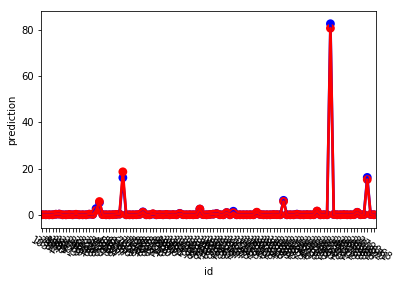

In [31]:
X_x = X_test.sample(100,random_state=10)
import seaborn as sb
%matplotlib inline
fig, ax = plt.subplots()
sb.pointplot(x='id', y='fact', data=X_x, ax=ax, color='b')
sb.pointplot(x='id', y='prediction', data=X_x, ax=ax, color='r')
labels = ax.get_xticklabels() 
ax.set_xticklabels(labels, rotation=-30)
sb.plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="carat", y="price",
                #hue="clarity", size="depth",
                #palette="ch:r=-.2,d=.3_r",
                #hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,
                data=X, ax=ax)